In [ ]:
import pandas as pd

#read the csv file
df = pd.read_csv('/content/drive/MyDrive/Sleep.csv')

df.rename(columns={'sr': 'snoring rate', 'rr':'respiration rate', 't': 'body temperature', 'lm':'limb movement',
                     'bo':'blood oxygen', 'rem':'eye movement', 'sr.1':'sleeping hours', 'hr':'heart rate','sl':'stress level'}, inplace=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(df.shape)

(5445, 9)


In [ ]:
class_counts = df['stress level'].value_counts()
print(class_counts)

stress level
1.0    1466
2.0    1415
0.0    1198
3.0     918
4.0     448
Name: count, dtype: int64


In [ ]:
import numpy as np

# Prepare the data
X = df.drop('stress level', axis=1)
y = pd.DataFrame(df['stress level'])

# Convert y to a 1D array
y = np.ravel(y)

In [ ]:
from mlxtend.preprocessing import minmax_scaling

X_scaled = minmax_scaling(X, columns=X.columns)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2, random_state=42,stratify = y, shuffle=True)


In [ ]:
len(X_valid)

1089

In [ ]:
from imblearn.over_sampling import ADASYN
from collections import Counter
# Apply ADASYN to the training data
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Print class distribution after oversampling
print("\nClass distribution after ADASYN oversampling:")
print(Counter(y_train_adasyn))


Class distribution after ADASYN oversampling:
Counter({4.0: 1174, 1.0: 1173, 0.0: 1171, 3.0: 1162, 2.0: 1134})


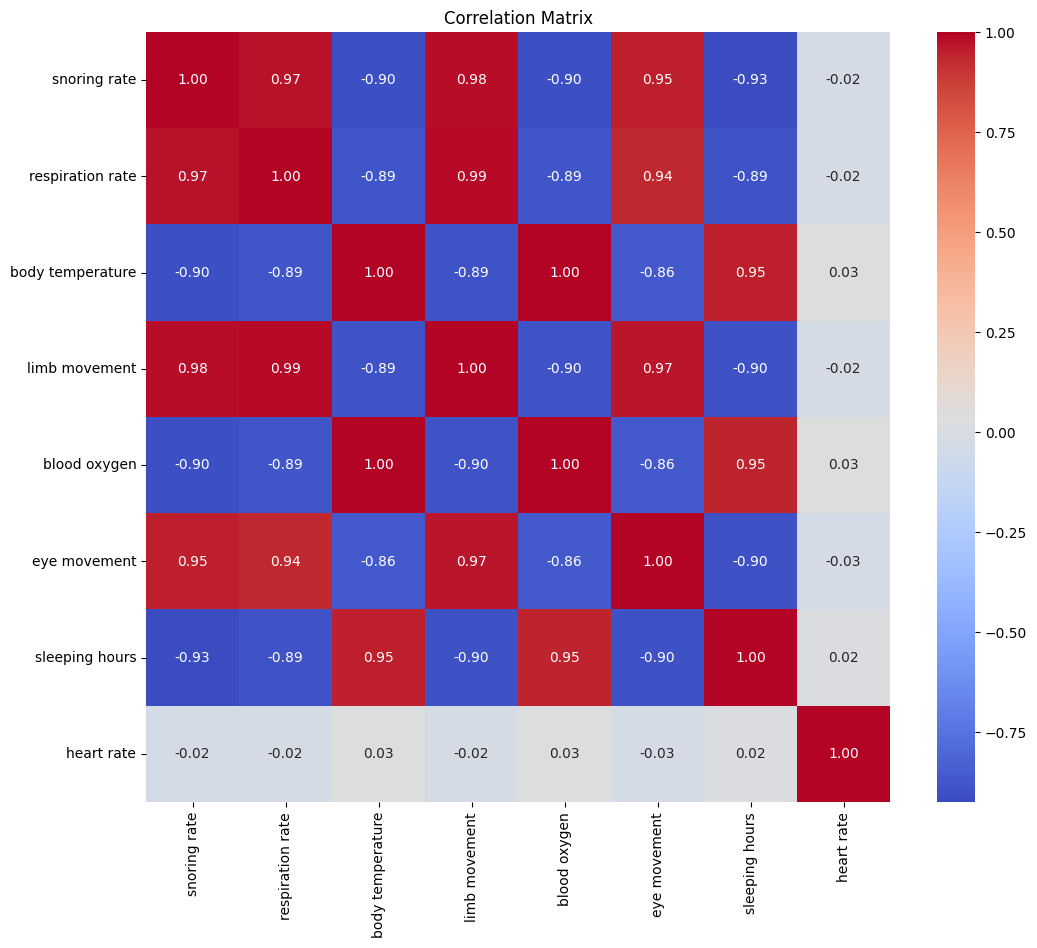

In [ ]:
# Visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
#Pearsons correlation
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_adasyn.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

5

In [ ]:
corr_features

{'blood oxygen',
 'eye movement',
 'limb movement',
 'respiration rate',
 'sleeping hours'}

In [ ]:
X_train_adasyn.drop(corr_features,axis=1)
X_valid.drop(corr_features,axis=1)

,snoring rate,body temperature,heart rate
2651,0.647286,0.527333,0.000000
2428,0.319286,0.734000,0.000000
2190,0.694286,0.459333,0.000000
304,0.513143,0.506133,0.709630
211,0.746857,0.353600,0.771852
...,...,...,...
4675,0.421429,0.651333,0.000000
557,0.798286,0.385600,0.801481
1323,0.483000,0.694000,0.000000
352,0.988114,0.264000,0.974321


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(multi_class='multinomial',max_iter=1000)
gnb = GaussianNB()
svc = SVC()
knn = KNeighborsClassifier()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score

models = [lr,gnb,svc,knn]
model_name = ['Logistic Regression', 'Gaussian Naive Bayes','SVC','KNN or k-Nearest Neighbors']

acc_scores = []
precision_scores = []
recall_scores = []
conf_matrices = []
for model in models:
    # Fit the model on the ADASYN-oversampled training data
    model.fit(X_train_adasyn.drop(corr_features, axis=1), y_train_adasyn)
    y_pred = model.predict(X_valid.drop(corr_features,axis=1))

    acc_model = accuracy_score(y_pred, y_valid)
    acc_scores.append(acc_model)

    precision = precision_score(y_valid, y_pred,average='weighted')
    precision_scores.append(precision)

    recall = recall_score(y_valid, y_pred,average='weighted')
    recall_scores.append(recall)

    conf_matrices.append(confusion_matrix(y_valid, y_pred))

models_acc = pd.DataFrame({'Model name': model_name, 'Accuracy scores': acc_scores,
                           'Precision scores': precision_scores, 'Recall scores': recall_scores})
models_acc.sort_values(by='Accuracy scores', ascending=False)

,Model name,Accuracy scores,Precision scores,Recall scores
0,Logistic Regression,0.882461,0.884807,0.882461
3,KNN or k-Nearest Neighbors,0.881543,0.882121,0.881543
1,Gaussian Naive Bayes,0.880624,0.883526,0.880624
2,SVC,0.879706,0.882173,0.879706


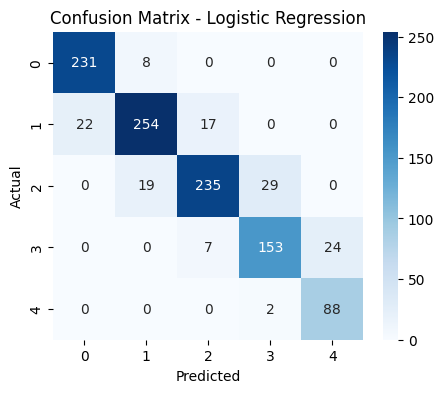

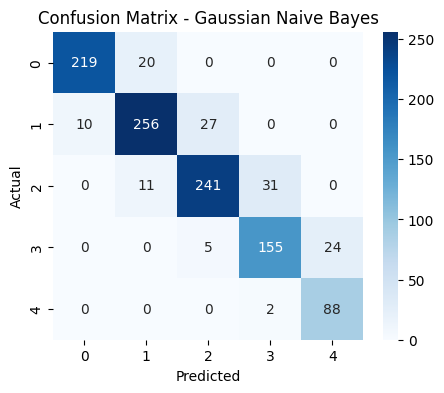

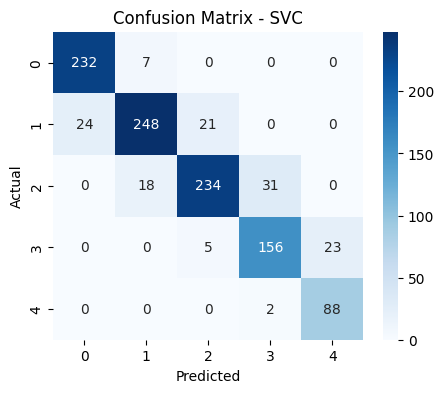

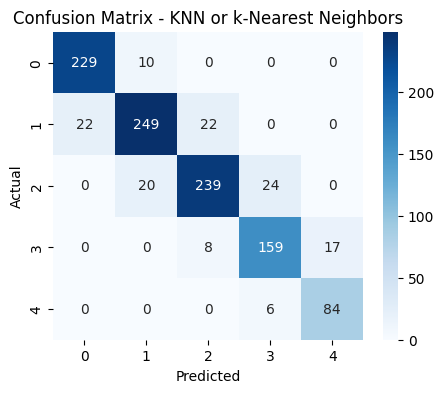

In [ ]:
# Visualize the confusion matrix for each model
for model_name, conf_matrix in zip(model_name, conf_matrices):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
# New data to predict stress level
new_data = [[47.0,97.2,52.0]]
print(lr.predict(new_data))

[0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
# New data to predict stress level
new_data = [[47.0,97.2,52.0]]
print(gnb.predict(new_data))

[0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


In [ ]:
# New data to predict stress level
new_data = [[47.0,97.2,52.0]]
print(svc.predict(new_data))

[4.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
# New data to predict stress level
new_data = [[47.0,97.2,52.0]]
print(knn.predict(new_data))

[0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
